In [1]:
from IPython import display
import pandas as pd

from utils import decision_tree as dt
from utils import definitions as defs

## ETL

In [2]:
df = pd.read_excel(defs.ETLED_DATA_PATH_step_2)

Y = df[defs.LABEL]
X = df.drop(defs.LABEL, axis=1)

In [3]:
categorical_feature_names = [
    defs.QUESTION_3,
    'pre4. Есть ответ на вопрос 4?',
    defs.QUESTION_5,
    defs.QUESTION_6,
    defs.QUESTION_7,
    defs.QUESTION_8,
    defs.QUESTION_9,
    'pre11. Есть ответ на вопрос 11?',
    defs.QUESTION_11,
    defs.QUESTION_12,
    defs.QUESTION_13,
    defs.QUESTION_14,
    defs.QUESTION_15,
    defs.QUESTION_16,
    defs.QUESTION_17,
    defs.QUESTION_18,
    defs.QUESTION_19,
    'pre20. Есть ответ на вопрос 20?',
    defs.QUESTION_20,
    defs.QUESTION_23,
    defs.QUESTION_25,
    defs.QUESTION_26,
    defs.QUESTION_27,
    defs.QUESTION_28,
    defs.QUESTION_29,
    defs.QUESTION_30,
    defs.QUESTION_31,
    defs.QUESTION_32,
    defs.QUESTION_33,
    defs.QUESTION_34,
    defs.QUESTION_35,
]

numerical_feature_names = [
    defs.QUESTION_2,
    defs.QUESTION_4,
    defs.QUESTION_22,
    defs.QUESTION_24,
]

special_cases = {
    'pre4. Есть ответ на вопрос 4?': defs.QUESTION_4,
    defs.QUESTION_6: defs.QUESTION_7,
    defs.QUESTION_8: defs.QUESTION_9,
    'pre11. Есть ответ на вопрос 11?': defs.QUESTION_11,
    'pre20. Есть ответ на вопрос 20?': defs.QUESTION_20,
    defs.QUESTION_23: defs.QUESTION_24,
    defs.QUESTION_27: defs.QUESTION_26,
}

## Модель дерева решений

In [4]:
tree = dt.DecisionTree()

In [5]:
tree.fit(X, Y, categorical_feature_names, numerical_feature_names, special_cases=special_cases)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.905066 to fit


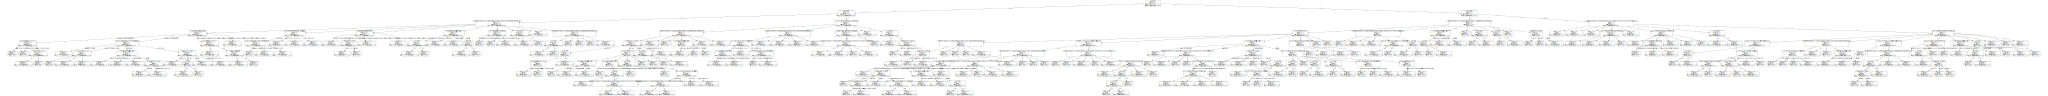

In [6]:
tree.render(rounded=True, show_impurity=True, show_num_samples=True, show_distribution=True, show_label=True, format='png')

In [7]:
display.Image('дерево решений.gv.png')

In [8]:
tree.feature_importances_

{'2. Возраст': 0.35260087000514667,
 '3. Семейное положение': 0.06571336132894225,
 '4. Если имеете супруга или партнера, как долго вы живете вместе (в годах)?': 0.0,
 '5. В какой семье Вы выросли?': 0.015057817421978505,
 '6. Жив ли хотя бы один из Ваших родителей (да/нет)?': 0.005406753911086744,
 '7. Если да, как часто вы общаетесь?': 0.0,
 '8. Есть ли у Вас дети (да/нет)?': 0.004548375883657963,
 '9. Если да, сколько?': 0.0,
 '11. Если да, как часто вы общаетесь?': 0.0,
 '12. Сколько человек живут вместе с Вами?': 0.03151674665778171,
 '13. Каковы Ваши взаимоотношения с соседями?': 0.019759472861037033,
 '14. Как часто Вы встречаетесь с друзьями?': 0.06187686320818744,
 '15. Есть ли у Вас домашние питомцы (да/нет)?': 0.011413848375418199,
 '16. В течение последних 7 дней, как часто Вы практиковали тяжелые физические нагрузки?': 0.053416336746018644,
 '17. В течение последних 7 дней, как часто Вы практиковали умеренные физические нагрузки?': 0.06027976492707739,
 '18. В течение посл

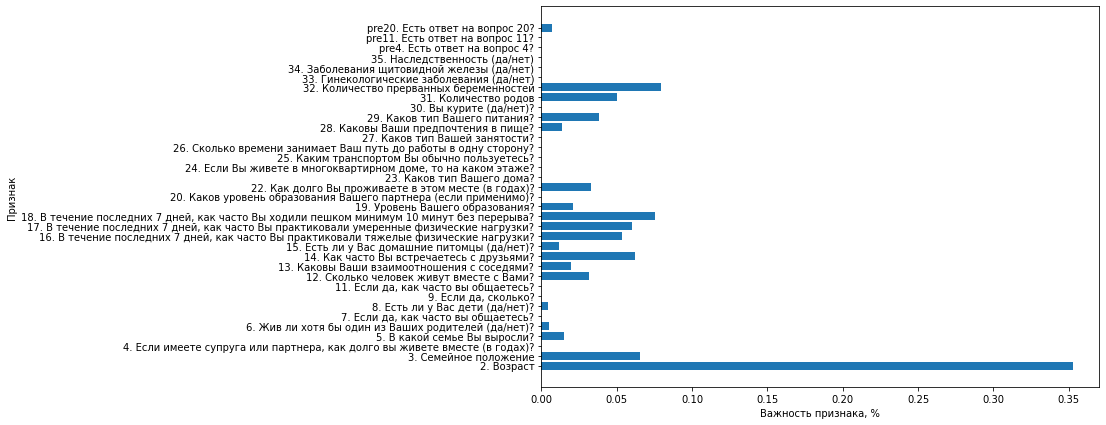

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.barh(list(tree.feature_importances_.keys()), tree.feature_importances_.values(), align='center')
#plt.yticks(list(range(len(feature_names))), feature_names)
plt.xlabel('Важность признака, %')
plt.ylabel('Признак')
plt.show()